<a href="https://colab.research.google.com/github/uuao/data2/blob/main/traffic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Evolution of Dynamic Graphs
An Application of [Spatio-Temporal Graph Neural Networks](https://arxiv.org/pdf/1709.04875.pdf) to Traffic Prediction

### Set Up

In [ ]:
# Note that this installation can take a while! Be patient!
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-geometric
!pip install torch-geometric-temporal

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=282114 sha256=8c742ef9ee882e57a636e5257cb1e8cf60381f4c3d45cf23e810c71ff763c310
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html
     |████████████████████████████████| 43 kB 919 kB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.12-cp37-cp37m-linux_x86_64.whl size=505740 sha256=83656a5f7f5e19492cde6781b06973c189089fbe161f111c779bf2f4ca9bdfd6
  Stored in directory: /root/.cache/pip/wheels/fb/e2/2f/44956c61e3299573ffe12da9d1374c7576ca0c5fb1fe1ed38c
Successfully built torch-sparse
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html
  Created wheel for torch-cluster: filename=torch_cluster-1.5.9-cp37-cp37m-linux_x86_64.whl size=3179

In [ ]:
from datetime import datetime
import geopy.distance # to compute distances between stations
import glob
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn import STConv
from tqdm import tqdm

## Part 1: Data Downloading and Cleaning

### 1. Downloading PeMS Data
We download the traffic data from the [PeMS Data Clearinghouse](https://pems.dot.ca.gov/?dnode=Clearinghouse), which requires setting up an account. We select the Station 5-Minute Type and restrict the stations to those in District 7. We also download the metadata for each station. Since PeMS discourages the use of automated scripts to retrieve data, we download the data for each day between May and June 2021 manually and made it available through Google Drive. 

Please begin by accessing this [Google Drive folder](https://drive.google.com/drive/folders/1EMo8aoGErMrYlDeq8btmuA91JfSexeLW?usp=sharing), click on the name of the folder (CSS224_Project) and select the [Add to My Drive option](https://stackoverflow.com/questions/53884509/import-google-drive-files-shared-with-by-you-in-colab) to gain access to the PeMS raw and processed data that we will be working with. You will be asked below to mount your Google Drive, which should then allow Colab to access these files seamlessly.

If you'd like to work with a specific range of dates or locations, feel free to manually download the files as described above and use the following code to pre-process them in the same manner by modifying the input files. 

If you'd like to skip this step, you can access our preprocessed data in [CS224_Project/Data/Processed_data/Graph_inputs](https://drive.google.com/drive/u/1/folders/1Xj3fo6y_o-ipzrDZukbrUkZlZjr1JohZ) and jump to [Part 2: Model Building and Training](#part_2).

In [ ]:
# Input files
PeMS_daily = os.path.join(
    'gdrive', 'MyDrive', 'CS224_Project', 'Data', 'PeMS', '*')
PeMS_metadata = os.path.join(
    'gdrive', 'MyDrive', 'CS224_Project', 'Data', 'd07_text_meta_2021_03_27.txt')
Yu_data = os.path.join(
    'gdrive', 'MyDrive', 'CS224_Project', 'Data', 'Yu_et_al', 'PeMS-M')

# Outputs
output_dir = os.path.join(
    'gdrive', 'MyDrive', 'CS224_Project', 'Data', 'Processed_data', 'Graph_Inputs')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


The following parameters determine the number of stations we will include in the processed dataset that will be fed into the model. We randomly sample 50 stations (out of 2,789 stations in District 7), but note that another strategy could be to download the data from stations in a narrower geographic region and include all available stations.

The PeMS dataset includes several observations for each station at each time interval, including average traffic speed and average occupancy. Feel free to modify the outcome variable below fo train on a different outcome!

In [ ]:
# Parameters
num_stations = 50
outcome_var = 'avg_speed'

We will now begin cleaning and pre-processing the PeMS raw data. 

In [ ]:
# List all of the daily files from May-June 2021
files = glob.glob(PeMS_daily)

In [ ]:
# Get the columns from the PeMS CSV
PeMS_columns = ['timestamp', 'station', 'district', 'freeway_num', 
              'direction_travel', 'lane_type', 'station_length',
              'samples', 'perc_observed', 'total_flow', 'avg_occupancy',
              'avg_speed']
PeMS_lane_columns = lambda x: ['lane_N_samples_{}'.format(x), 
                               'lane_N_flow_{}'.format(x), 
                               'lane_N_avg_occ_{}'.format(x),
                               'lane_N_avg_speed_{}'.format(x), 
                               'lane_N_observed_{}'.format(x)]       

PeMS_all_columns = PeMS_columns.copy()
for i in range(1,9):
    PeMS_all_columns += PeMS_lane_columns(i)

In [ ]:
# Randomly select stations to build the dataset
np.random.seed(42)

station_file = files[0]
station_file_content = pd.read_csv(station_file,  header=0, names=PeMS_all_columns)
station_file_content = station_file_content[PeMS_columns]

station_file_content = station_file_content.dropna(subset=[outcome_var])
unique_stations = station_file_content['station'].unique()
selected_stations = np.random.choice(
    unique_stations, size=num_stations, replace=False)

In [ ]:
# Build two-months of data for the selected stations/nodes
station_data = pd.DataFrame({col: []} for col in PeMS_columns)

for station_file in tqdm(files):
    # Get file date
    file_date_str = station_file.split(os.path.sep)[-1].split('.')[0]
    file_date = datetime(2021, int(file_date_str.split('_')[-2]), 
                         int(file_date_str.split('_')[-1]))

    # Check if weekday
    if file_date.weekday() < 5:
        # Read CSV
        station_file_content = pd.read_csv(
            station_file, header=0, names=PeMS_all_columns)
        
        # Keep only columns of interest
        station_file_content = station_file_content[PeMS_columns]

        # Keep stations
        station_file_content = station_file_content[
            station_file_content['station'].isin(selected_stations)]

        # Append to dataset
        station_data = pd.concat([station_data, station_file_content])

100%|██████████| 61/61 [03:38<00:00,  3.59s/it]


In [ ]:
# Drop the 11 rows with missing values
station_data = station_data.dropna(subset=['timestamp', outcome_var])

At this stage, we've generated a dataset `station_data` containing the average traffic speeds observed for each 5-minute interval in our selected date range at each of the 50 randomly selected stations.

In [ ]:
station_data.head()

,timestamp,station,district,freeway_num,direction_travel,lane_type,station_length,samples,perc_observed,total_flow,avg_occupancy,avg_speed
746,05/04/2021 00:00:00,716784,7,605,N,ML,0.465,0,0,90,0.0161,66.3
865,05/04/2021 00:00:00,716934,7,5,S,ML,0.546,50,60,226,0.0526,70.1
890,05/04/2021 00:00:00,716963,7,5,N,ML,0.36,0,0,188,0.0419,71.7
1082,05/04/2021 00:00:00,717196,7,10,W,ML,0.314,40,0,179,0.0449,66.5
1091,05/04/2021 00:00:00,717209,7,10,W,ML,0.275,0,0,201,0.0357,70.3


In [ ]:
station_data.shape

(619161, 12)

#### Download station metadata
In order to compute the distance between stations and build the adjacency matrix weights as described in the blog, we also need to download the metadata for each station. This will provide us with the (latitude, longitude) coordinate pairs for each station, which in turn will allow us to compute the distance between each pair of nodes. 

In [ ]:
station_metadata = pd.read_table(PeMS_metadata)
station_metadata = station_metadata[['ID', 'Latitude', 'Longitude']]

In [ ]:
# Filter for selected stations
station_metadata = station_metadata[station_metadata['ID'].isin(selected_stations)]

In [ ]:
station_metadata.head()

,ID,Latitude,Longitude
747,716784,33.894297,-118.104669
866,716934,34.019879,-118.181588
891,716963,34.164088,-118.295568
1083,717196,34.072264,-117.909076
1092,717209,34.072029,-117.882752


### 2. Build adjacency matrix and node features

With the average traffic speeds for each 5-minute interval and the geographic location of each station in hand, we now build the inputs to the model. These consist of a pair $(V, W)$, where $V$ includes the node features (traffic speeds) of each node in the graph at each point in time and $W$ contains the weights for the edges between each pair of nodes. For this reason, $V$ will be a matrix of size $(T, N)$, while $W$ will have shape $(N, N)$, where $T$ is the number of 5-minute intervals in the selected date range and $N=50$ is the number of stations.

#### Node features ($V$)

In [ ]:
# Keep only the required columns (time interval, station ID and the outcome variable)
station_data = station_data[['timestamp', 'station', outcome_var]]
station_data[outcome_var] = pd.to_numeric(station_data[outcome_var])

In [ ]:
# Reshape the dataset and aggregate the traffic speeds in each time interval
V = station_data.pivot_table(index=['timestamp'], columns=['station'], values=outcome_var, aggfunc='mean')

In [ ]:
V.head()

station,716784,716934,716963,717196,717209,717340,717461,717492,717746,717756,717892,717922,718014,718016,718151,718414,718466,759576,759858,760002,760345,760465,760558,760718,761388,763458,763590,764037,764295,764435,764669,766337,766505,766534,766641,767585,769062,770386,770407,771329,771432,772919,773330,773630,774227,774389,775100,776081,776228,776631
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
05/03/2021 00:00:00,66.2,68.5,69.5,66.5,70.1,69.7,59.0,63.2,69.1,65.0,65.0,67.7,69.3,67.2,65.8,70.7,68.4,66.9,61.3,69.3,65.0,65.0,68.3,68.2,65.0,69.3,68.2,70.7,65.0,76.8,65.0,65.8,66.9,65.0,65.0,72.7,65.0,64.4,65.0,65.0,63.3,65.0,71.5,65.1,67.4,67.7,65.9,71.0,63.5,65.0
05/03/2021 00:05:00,66.9,68.0,68.5,66.7,70.1,70.4,60.8,64.7,69.7,65.0,64.9,59.3,69.0,63.7,66.7,70.4,68.7,66.9,63.4,69.9,65.1,65.1,68.2,66.8,65.0,69.0,69.3,70.7,65.1,70.6,65.1,65.8,67.2,65.0,64.9,70.6,65.1,64.4,65.0,65.3,63.3,65.2,71.6,64.9,67.9,68.7,68.4,71.3,60.7,64.9
05/03/2021 00:10:00,67.0,68.5,68.5,66.1,70.0,68.7,58.3,62.8,70.6,65.1,65.0,58.3,68.9,64.2,66.2,70.4,68.1,66.7,62.6,69.7,65.1,65.1,67.1,68.5,64.8,68.9,68.5,70.8,65.1,75.3,65.1,65.8,67.3,65.0,64.9,71.8,65.1,64.3,64.9,65.3,62.9,65.3,70.3,64.9,65.7,66.3,52.4,70.2,61.4,65.0
05/03/2021 00:15:00,67.0,70.7,69.5,66.3,70.0,69.2,57.7,63.5,70.3,65.1,65.0,55.7,68.8,65.3,65.6,70.1,68.6,66.9,61.1,69.6,65.1,65.1,68.8,68.0,64.4,68.8,68.9,70.6,65.1,76.2,65.1,65.6,67.4,64.9,64.9,72.1,65.1,64.6,65.0,65.1,62.2,65.1,72.1,65.2,69.4,64.5,39.9,70.3,61.4,65.0
05/03/2021 00:20:00,66.7,71.1,68.5,66.7,69.9,68.2,58.2,62.7,70.9,65.6,64.9,63.4,68.9,65.9,66.0,70.2,68.3,67.7,63.0,68.9,65.1,65.1,68.6,67.3,64.7,68.9,67.0,70.5,65.1,77.6,65.1,66.0,67.6,64.9,64.9,71.1,65.1,64.6,65.0,65.4,63.1,65.1,70.6,65.1,66.2,65.9,53.4,69.5,62.1,64.9


In [ ]:
V.shape

(12384, 50)

#### Adjacency matrix ($W$)

For the adjacency matrix, we begin by computing the distances between each pair of nodes in the graph using their geographic coordinates and the `geopy.distance.vincenty` function. 

In [ ]:
# Compute distances
distances  = pd.crosstab(station_metadata.ID, station_metadata.ID, normalize=True)
distances_std = []

for station_i in selected_stations:
    for station_j in selected_stations:
        if station_i == station_j: 
            distances.at[station_j, station_i] = 0
        else:
            # Compute distance between stations
            station_i_meta = station_metadata[station_metadata['ID']==station_i]
            station_j_meta = station_metadata[station_metadata['ID']==station_j]
            d_ij = geopy.distance.vincenty(
                (station_i_meta['Latitude'].values[0], station_i_meta['Longitude'].values[0]), 
                (station_j_meta['Latitude'].values[0], station_j_meta['Longitude'].values[0])).m
            distances.at[station_j, station_i] = d_ij
            distances_std.append(d_ij)

distances_std = np.std(distances_std)

This results in a matrix of size $(N,N)$ with zeros on the diagonal, since the distance from each station to itself is zero. 

In [ ]:
distances.head()

ID,716784,716934,716963,717196,717209,717340,717461,717492,717746,717756,717892,717922,718014,718016,718151,718414,718466,759576,759858,760002,760345,760465,760558,760718,761388,763458,763590,764037,764295,764435,764669,766337,766505,766534,766641,767585,769062,770386,770407,771329,771432,772919,773330,773630,774227,774389,775100,776081,776228,776631
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
716784,0.000000,15639.251042,34733.063121,26764.373532,28445.465767,21425.857023,27975.646240,38541.463127,20082.416695,22861.849591,8231.917573,12921.938857,15293.387996,16516.587874,7891.047422,28334.432048,3065.244357,16377.740261,56694.508063,57486.885532,2348.759945,18831.888513,10556.553087,68892.081744,31050.302824,19276.429860,26142.258077,21516.728642,64867.909056,13987.888345,24630.151103,17227.641669,16369.690576,5387.645279,35611.047710,32131.350811,24891.230441,36133.851325,31046.044038,77814.983499,81256.984241,32507.327447,16907.818345,78267.132579,32781.670549,13633.431264,34724.291522,47452.412264,16357.611395,132895.780894
716934,15639.251042,0.000000,19144.759830,25824.569917,28192.844011,25597.626341,13290.168220,23713.778423,21594.973785,21764.903171,10823.101811,11119.368957,768.293500,1785.724790,10014.517875,16675.413475,13001.358124,1281.001425,41395.993787,45026.623324,13303.660279,15356.104687,10779.766635,55009.889942,27694.193523,5773.925297,31636.210238,8692.648012,49296.097273,2115.582350,21498.613671,20605.713080,20836.163484,20881.611974,39676.647853,16716.050289,31201.276633,20983.691408,27710.500158,65554.239683,68417.712303,29882.850035,12728.424232,62916.613307,24406.344694,23822.802373,37210.291326,33602.374706,1590.178872,121320.243283
716963,34733.063121,19144.759830,0.000000,37082.691364,39430.281191,40583.008750,8719.524181,7958.631914,33574.849252,31489.856549,29388.872465,27798.827071,19587.490249,18598.359868,28155.993825,15657.109397,32146.115931,18355.794563,22579.889513,31778.015285,32415.499665,26338.885814,27495.202270,38463.515428,36141.317120,16289.875138,46471.140913,15411.861929,30151.413687,21004.204559,29362.582583,34268.722838,35117.839329,39868.965588,52523.592374,6594.131230,46592.655400,8931.808252,36174.283796,51366.029364,53196.569833,38492.559983,26942.172861,43926.365214,24091.101344,40527.053694,49096.913950,18717.966091,18713.201407,106990.704084
717196,26764.373532,25824.569917,37082.691364,0.000000,2430.018948,8675.511372,36287.840238,44498.037016,44430.564384,45906.338829,19943.365728,15991.898833,25079.909951,24496.231176,29511.381181,41972.505079,24564.974050,27036.703953,58184.466701,68122.368635,25815.168455,39941.595591,32362.068566,75498.774277,5388.097097,31385.379143,11769.420853,34207.760384,63020.375138,24237.618517,46417.939259,42259.244811,41808.235936,30247.491713,15471.868201,30880.791707,12902.707821,31832.287244,5362.316022,88232.838130,90260.046438,5962.815261,13147.522455,77878.076760,50201.869821,40393.291788,12059.596329,55425.631318,24595.794609,144005.337032
717209,28445.465767,28192.844011,39430.281191,2430.018948,0.000000,8913.065128,38716.673241,46882.843523,46505.773653,48074.238313,21941.446844,18169.571207,27444.418971,26886.953064,31578.151044,44388.702469,26386.028937,29412.672888,60389.155481,70531.371241,27631.449897,42167.665601,34476.199566,77819.613972,5862.075699,33778.282847,10671.012248,36609.200921,65055.050150,26573.891532,48651.795300,44266.589903,43773.229909,31658.322416,13210.495799,33184.782850,12050.636792,34005.969013,5825.931198,90621.499860,92619.473455,5418.392523,15486.744278,79929.817095,52584.200378,42074.180591,9673.173038,57814.929099,26983.365931,146379.137388


In the next step, we compute $w_{ij}$ for each pair of nodes $(i, j)$ in the graph as presented in Yu et al. (2018):

$w_ij = \begin{cases} \exp{(-\frac{d_{ij}^2}{\sigma^2})}, i\neq j \text{ and } \exp{(-\frac{d_{ij}^2}{\sigma^2})} \leq \epsilon \\ 
0 \text{ otherwise }
\end{cases}$

In this case, $d_{ij}$ for each pair of nodes $(i, j)$ is the distance between stations that we have computed above. $\sigma$ is the standard deviation of the distances, and we set $\epsilon = 0.1$ in line with the original authors to modif the sparsity of $W$.

In [ ]:
W  = pd.crosstab(station_metadata.ID, station_metadata.ID, normalize=True)

epsilon = 0.1
sigma = distances_std

for station_i in selected_stations:
    for station_j in selected_stations:
        if station_i == station_j: 
            W.at[station_j, station_i] = 0
        else:
            # Compute distance between stations
            d_ij = distances.loc[station_j, station_i]
            
            # Compute weight w_ij
            w_ij = np.exp(-d_ij**2 / sigma**2)
            
            if w_ij >= epsilon:
                W.at[station_j, station_i] = w_ij

In [ ]:
W.head()

ID,716784,716934,716963,717196,717209,717340,717461,717492,717746,717756,717892,717922,718014,718016,718151,718414,718466,759576,759858,760002,760345,760465,760558,760718,761388,763458,763590,764037,764295,764435,764669,766337,766505,766534,766641,767585,769062,770386,770407,771329,771432,772919,773330,773630,774227,774389,775100,776081,776228,776631
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
716784,0.000000,0.711394,0.186447,0.368865,0.324152,0.527744,0.336338,0.126422,0.570350,0.483025,0.909968,0.792569,0.722070,0.683994,0.916957,0.327009,0.987004,0.688357,0.000000,0.00000,0.992349,0.610332,0.856282,0.000000,0.261241,0.596105,0.386162,0.524885,0.000000,0.761540,0.429725,0.661522,0.688610,0.960393,0.171085,0.237543,0.422059,0.162380,0.261337,0.0,0.0,0.229640,0.671653,0.0,0.223984,0.771992,0.186605,0.000000,0.688989,0.0
716934,0.711394,0.000000,0.600318,0.395141,0.330674,0.401613,0.781990,0.457064,0.522426,0.517094,0.849515,0.841861,0.999179,0.995570,0.869679,0.678992,0.790301,0.997718,0.000000,0.00000,0.781599,0.720140,0.850623,0.000000,0.343756,0.954645,0.248218,0.900142,0.000000,0.993788,0.525455,0.553691,0.546377,0.544937,0.111721,0.677710,0.257845,0.541704,0.343324,0.0,0.0,0.288439,0.798065,0.0,0.436342,0.453778,0.145477,0.207623,0.996486,0.0
716963,0.186447,0.600318,0.000000,0.147410,0.114794,0.100960,0.899556,0.915591,0.208158,0.251431,0.300440,0.340988,0.586156,0.617805,0.331631,0.710841,0.237229,0.625563,0.491719,0.24513,0.231554,0.380654,0.349052,0.127483,0.162258,0.691113,0.000000,0.718422,0.282036,0.541055,0.301087,0.194952,0.179599,0.109366,0.000000,0.941257,0.000000,0.894875,0.161720,0.0,0.0,0.127087,0.363994,0.0,0.445729,0.101600,0.000000,0.613977,0.614130,0.0
717196,0.368865,0.395141,0.147410,0.000000,0.991812,0.900515,0.159878,0.000000,0.000000,0.000000,0.574787,0.700431,0.416555,0.433679,0.297437,0.000000,0.431648,0.361417,0.000000,0.00000,0.395408,0.108487,0.232672,0.000000,0.960386,0.253741,0.824601,0.196089,0.000000,0.441356,0.000000,0.000000,0.000000,0.279767,0.716571,0.265087,0.793117,0.243954,0.960757,0.0,0.0,0.951703,0.786106,0.0,0.000000,0.103142,0.816701,0.000000,0.430738,0.0
717209,0.324152,0.330674,0.114794,0.991812,0.000000,0.895292,0.124061,0.000000,0.000000,0.000000,0.511568,0.631515,0.350411,0.365503,0.249490,0.000000,0.379339,0.299855,0.000000,0.00000,0.345421,0.000000,0.191119,0.000000,0.953283,0.204224,0.853391,0.154748,0.000000,0.374120,0.000000,0.000000,0.000000,0.247735,0.784292,0.215843,0.816946,0.199883,0.953844,0.0,0.0,0.959949,0.716111,0.0,0.000000,0.000000,0.877854,0.000000,0.362870,0.0


Finally, we save our generated inputs $(V, W)$ to file, which will be used in the next section. 

In [ ]:
# Save to file
V.to_csv(os.path.join(output_dir, 'V_{}.csv'.format(num_stations)), index=False)
W.to_csv(os.path.join(output_dir, 'W_{}.csv'.format(num_stations)), index=False)
station_metadata.to_csv(os.path.join(output_dir, 'station_meta_{}.csv'.format(num_stations)), index=False)

<a name="part_2"></a>
## Part 2: Model Building and Training


### 1. Build the Model

First construct a class to represent our model. Recall the model architecture: 

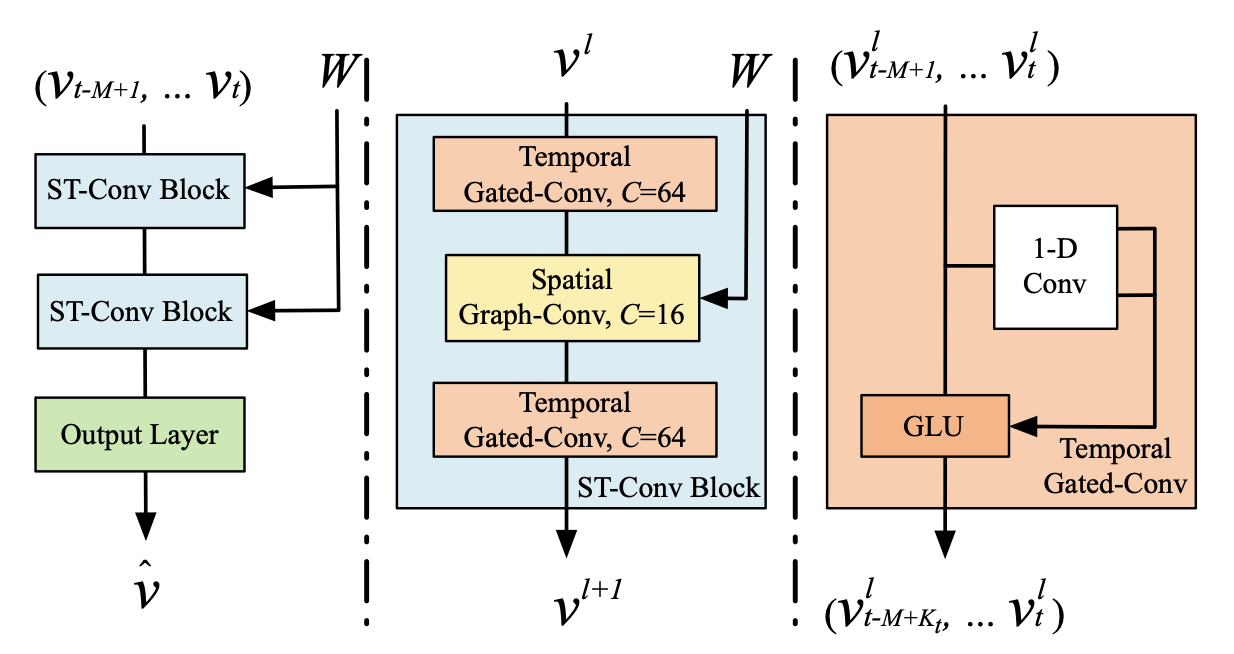

source: [Yu et. al. (2018)](https://arxiv.org/pdf/1709.04875.pdf)

Conveniently, PyG-Temporal already has an implementation of the ST-Conv block. All we have to do is create the Output Layer, which consists of a the following:

1. Temporal convolution
2. Layer normalization
3. Temporal convolution
4. Fully connected layer

4 is implemented via the `FullyConvLayer` class, then combined with 1-3 in the `OutputLayer` class. Note that much of the code for these classes is recycled from Hao Wei's implementation that he describes in [this Towards Data Science article](https://towardsdatascience.com/build-your-first-graph-neural-network-model-to-predict-traffic-speed-in-20-minutes-b593f8f838e5).

We put everything together in the `TrafficModel` class.

In [ ]:
# adapted from Hao Wei
class FullyConnLayer(nn.Module):
    def __init__(self, c):
        super(FullyConnLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)

# adapted from Hao Wei
class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation = 1, padding = (0,0))
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation = 1, padding = (0,0))
        self.fc = FullyConnLayer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)

        return self.fc(x_t2)

# final model
# a specified number of STConv blocks, followed by an output layer
class TrafficModel(torch.nn.Module):
    def __init__(self, device, num_nodes, channel_size_list, num_layers, 
                 kernel_size, K, window_size, \
                 normalization = 'sym', bias = True):
    # num_nodes = number of nodes in the input graph
    # channel_size_list =  2d array representing feature dimensions throughout the model
    # num_layers = number of STConv blocks
    # kernel_size = length of the temporal kernel
    # K = size of the chebyshev filter for the spatial convolution
    # window_size = number of historical time steps to consider

        super(TrafficModel, self).__init__()
        self.layers = nn.ModuleList([])
        # add STConv blocks
        for l in range(num_layers):
            input_size, hidden_size, output_size = \
            channel_size_list[l][0], channel_size_list[l][1], \
            channel_size_list[l][2]
            self.layers.append(STConv(num_nodes, input_size, hidden_size, \
                                      output_size, kernel_size, K, \
                                      normalization, bias))
        # add output layer
        self.layers.append(OutputLayer(channel_size_list[-1][-1], \
                                       window_size - 2 * num_layers * (kernel_size - 1), \
                                       num_nodes))
        # CUDA if available
        for layer in self.layers:
            layer = layer.to(device)

    def forward(self, x, edge_index, edge_weight):
        for layer in self.layers[:-1]:
          x = layer(x, edge_index, edge_weight)
        out_layer = self.layers[-1]
        x = x.permute(0, 3, 1, 2)
        x = out_layer(x)
        return x

### 2. Define Parameters

Training this model is quite computationally intensive. We've altered the parameters here from what we used to train so you'd be able to run the training script directly in the notebook. Namely,
* You'll be training for 2 epochs in this colab, while we trained for 7 epochs using Google Cloud
* You'll be predicting future traffic with 20 historical time steps, while we used 144 historical time steps
* You'll be training on 5% of the data, while we trained on 70% of the data. The validation and test set sizes have been adjusted in this colab as well.


In [ ]:
# model parameters
channels = np.array([[1, 16, 64], [64, 16, 64]]) # sequence of channel sizes
                                                 # should start with 1
kernel_size = 3 # size of temporal kernel
K = 3 # chebyshev filter size

# training parameters
learning_rate = 0.001
batch_size = 50
num_epochs = 2 # note that we trained for 7 epochs using Google Cloud
num_layers = 2 # number of STConv blocks
n_his = 20 # number of historical time steps to consider
           # our actual n_his value was 144
n_pred = 5 # steps in the future we want to predict
           # e.g. we use n_his time steps to predict 1 time step, which is 5 steps in the future
train_prop = 0.03 # Our actual training set proportion was 0.7
val_prop = 0.02 # Our actual training set proportion was 0.2
test_prop = 0.01 # Our actual training set proportion was 0.1
#test_prop = 1 - train_prop - val_prop

# model save path
## CHANGE THIS TO A LOCATION IN YOUR DRIVE!
model_save_path = os.path.join(
    'gdrive', 'MyDrive', 'CS224_Project', 'model_save', 'best_model.pt')

### 2. Load and Process Data

Our next step is to take the processed data we generated in Part 1 and create training, validation, and test sets.

In our traffic prediction model, observations will be, for each node, a sequence of past traffic speed readings as the input features and a future traffic speed reading as the target. 

Let's write a helper function `data_transform` to produce these inputs and targets from slices of our node feature matrix $V$. 

Note that much of this code has been adapted from Hao Wei's implementation that he describes in [this Towards Data Science article](https://towardsdatascience.com/build-your-first-graph-neural-network-model-to-predict-traffic-speed-in-20-minutes-b593f8f838e5).

In [ ]:
# adapted from Hao Wei
def data_transform(data, n_his, n_pred, device):
    # data = slice of V matrix
    # n_his = number of historical speed observations to consider
    # n_pred = number of time steps in the future to predict

    num_nodes = data.shape[1]
    num_obs = len(data) - n_his - n_pred
    x = np.zeros([num_obs, n_his, num_nodes, 1])
    y = np.zeros([num_obs, num_nodes])
    
    obs_idx = 0
    for i in range(num_obs):
        head = i
        tail = i + n_his
        x[obs_idx, :, :, :] = data[head: tail].reshape(n_his, num_nodes, 1)
        y[obs_idx] = data[tail + n_pred - 1]
        obs_idx += 1

    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)

Now let's go ahead and convert our processed data into a form we can use to train our model.

In [ ]:
weighted_adj_matrix_path = os.path.join(
    'gdrive', 'MyDrive', 'CS224_Project', 'Data', 'Processed_data', 
    'Graph_Inputs', 'W_50.csv')
W = pd.read_csv(weighted_adj_matrix_path)

feature_vectors_path = os.path.join(
    'gdrive', 'MyDrive', 'CS224_Project', 'Data', 'Processed_data', 
    'Graph_Inputs', 'V_50.csv')
V = pd.read_csv(feature_vectors_path)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() \
else torch.device("cpu")

In [ ]:
# adapted from Hao Wei

# get graph attributes
num_samples, num_nodes = V.shape

# get splits of V matrix
len_train = round(num_samples * train_prop)
len_val = round(num_samples * val_prop)
train = V[ : len_train]
val = V[len_train : len_train + len_val]
test = V[len_train + len_val : len_train + len_val + round(num_samples * test_prop)]

# normalize values
scaler = StandardScaler()
train = np.nan_to_num(scaler.fit_transform(train))
val = np.nan_to_num(scaler.transform(val))
test = np.nan_to_num(scaler.transform(test))

# create training examples using helper function
x_train, y_train = data_transform(train, n_his, n_pred, device)
x_val, y_val = data_transform(val, n_his, n_pred, device)
x_test, y_test = data_transform(test, n_his, n_pred, device)

# create torch data iterables for training
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

# format graph for pyg layer inputs
G = sp.coo_matrix(W)
edge_index = torch.tensor(np.array([G.row, G.col]), dtype=torch.int64).to(device)
edge_weight = torch.tensor(G.data).float().to(device)

### 3. Train Model

First let's initialize our model and define our loss and optimizer. Our loss function will be MSE loss, and we'll use an Adam optimizer.

In [ ]:
# build model
model = TrafficModel(device, num_nodes, channels, num_layers, kernel_size, K, \
                     n_his, normalization = 'sym', bias = True).to(device)

# define loss function
loss = nn.MSELoss()
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 

Now it's time to train! The following script will train and save our model. Note that much of the following code is adapted from Hao Wei's implementation that he describes in [this Towards Data Science article](https://towardsdatascience.com/build-your-first-graph-neural-network-model-to-predict-traffic-speed-in-20-minutes-b593f8f838e5).

In [ ]:
# adapted from Hao Wei
def evaluate_model(model, loss, data_iter, edge_index, edge_weight, device):
  model.eval()
  l_sum, n = 0.0, 0
  with torch.no_grad():
      for x, y in data_iter:
          y_pred = model(x.to(device), edge_index, edge_weight).view(len(x), -1)
          l = loss(y_pred, y)
          l_sum += l.item() * y.shape[0]
          n += y.shape[0]
      return l_sum / n

# adapted from Hao Wei
def evaluate_metric(model, data_iter, scaler, edge_index, edge_weight, device):
    model.eval()
    with torch.no_grad():
        mae, mape, mse = [], [], []
        for x, y in data_iter:
            y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
            y_pred = scaler.inverse_transform(model(x.to(device), \
                                                    edge_index, \
                                                    edge_weight).view(len(x), -1).cpu().numpy()).reshape(-1)
            d = np.abs(y - y_pred)
            mae += d.tolist()
            mape += (d / y).tolist()
            mse += (d ** 2).tolist()
        MAE = np.array(mae).mean()
        MAPE = np.array(mape).mean()
        RMSE = np.sqrt(np.array(mse).mean())
        return MAE, MAPE, RMSE

In [ ]:
min_val_loss = np.inf
for epoch in tqdm(range(1, num_epochs + 1), desc = 'Epoch', position = 0):
  l_sum, n = 0.0, 0

  model.train()

  for x, y in tqdm(train_iter, desc = 'Batch', position = 0):
    # get model predictions and compute loss
    y_pred = model(x.to(device), edge_index, edge_weight).view(len(x), -1)
    l = loss(y_pred, y)
    # backpropogation
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    l_sum += l.item() * y.shape[0]
    n += y.shape[0]

  # compute validation loss
  val_loss = evaluate_model(model, loss, val_iter, edge_index, edge_weight, device)
  # save the model if the validation loss is less than the current min validation loss
  if val_loss < min_val_loss:
      min_val_loss = val_loss
      torch.save(model.state_dict(), model_save_path)
  print("epoch", epoch, ", train loss:", l_sum / n, ", validation loss:", val_loss)

Epoch:  50%|█████     | 1/2 [00:57<00:57, 57.44s/it]

epoch 1 , train loss: 0.7344951167573847 , validation loss: 0.7037142271284565


Epoch: 100%|██████████| 2/2 [01:54<00:00, 57.22s/it]

epoch 2 , train loss: 0.4918104234964772 , validation loss: 0.6348906176106277


### 4. Evaluate Model

Wooooooo!! Our model is trained! Now let's see how it performed on the test set. Remember that optimized our parameters for runtime, not model performance, so the performance metrics will not be as strong as what you saw in our blog post.

In [ ]:
# load model with lowest validation lost
best_model = TrafficModel(device, num_nodes, channels, num_layers, kernel_size, K, \
                     n_his, normalization = 'sym', bias = True).to(device)
best_model.load_state_dict(torch.load(model_save_path))

# evaluate model on test set
l = evaluate_model(best_model, loss, test_iter, edge_index, edge_weight, device)
MAE, MAPE, RMSE = evaluate_metric(best_model, test_iter, scaler, edge_index, edge_weight, device)
print("test loss:", l, "\nMAE:", MAE, ", MAPE:", MAPE, ", RMSE:", RMSE)

test loss: 1.2911358626201899 
MAE: 5.452625286795876 , MAPE: 0.15514905235561147 , RMSE: 9.280047024938801


If you'd like, you can run the following code to grab your model's predictions for the final day of your training set. Then you can visually compare the predictions with the actual data.

In [ ]:
# model you want to use to predict
predict_model = best_model

# define save path
pred_save_path = os.path.join(
    'gdrive', 'MyDrive', 'CS224_Project', 'Data', 'Processed_data', 'predictions_testing.csv')

In [ ]:
def get_predictions(model, pred_iter, scaler, edge_index, edge_weight, num_nodes, device):
    model.eval()
    with torch.no_grad():
      for x, y in pred_iter:
        y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
        y_pred = scaler.inverse_transform(model(x.to(device), \
                                                edge_index, \
                                                edge_weight).view(len(x), -1).cpu().numpy()).reshape(-1)
        y_pred = y_pred.reshape(-1, num_nodes)
      
      return y, y_pred

In [ ]:
# create prediction set (last day)
pred_set = V[(-288 - n_his - n_pred):]
pred_set = np.nan_to_num(scaler.transform(pred_set))
x_pred, y_pred = data_transform(pred_set, n_his, n_pred, device)
pred_data = torch.utils.data.TensorDataset(x_pred, y_pred)
pred_iter = torch.utils.data.DataLoader(pred_data, 288 + n_his + n_pred + 1)

# get predictions for last day
predictions = get_predictions(predict_model, pred_iter, scaler, edge_index, edge_weight, 50, device)
np.savetxt(pred_save_path, predictions[1], delimiter=',')

Congrats on completing this project! We hope you found it helpful and fun! We've only scratched the surface of [Pytorch Geometric](https://github.com/pyg-team/pytorch_geometric)'s capabilities, so we encourage you to explore other models as well. 

Happy coding!

## References

California Department of Transportation. Caltrans Performance Measurement System (PeMS). URL: https://pems.dot.ca.gov/ [last accessed December 7, 2021]

Charles R. Harris et al. "Array programming with NumPy". In: Nature 585.7825 (Sept. 2020), pp. 357–362.DOI:10.1038/s41586–020–2649–2. URL: https://doi.org/10.1038/s41586-020-2649-2.

Fey, M., Lenssen, J. Fast Graph Representation Learning with PyTorch Geometric. (2019) arXiv:1903.02428.

The pandas development team.pandas-dev/pandas: Pandas. Version latest. Feb. 2020. DOI: 10.5281/zenodo.3509134. URL: https://doi.org/10.5281/zenodo.3509134.

Adam Paszke et al. "PyTorch: An Imperative Style, High-Performance Deep Learning Library". In: Advances inNeural Information Processing Systems 32. Ed. by H. Wallach et al. Curran Associates, Inc., 2019, pp. 8024–8035. URL:http://papers.neurips.cc/paper/9015- pytorch- an- imperative- style- high-performance-deep-learning-library.pdf.

Rozemberczki, B., Scherer, P., He, Y., Panagopoulos, G., Riedel, A., Astefanoaei, M., Kiss, O., Beres, F., Lopez, G., Collignon, N., and Sarkar, R. PyTorch Geometric Temporal: Spatiotemporal SignalProcessing with Neural Machine Learning Models. In Proceedings of the 30th ACM International Conference on Information and Knowledge Management (2021), p. 4564-4573.

Vivek, S. (2021, November 25). Visualizing real-time traffic patterns using here Traffic Api. Medium. Retrieved December 9, 2021, from https://towardsdatascience.com/visualizing-real-time-traffic-patterns-using-here-traffic-api-5f61528d563.

Yu, B., Yin, H., and Zhu, Z. Spatio-Temporal Graph Convolutional Networks: A Deep Learning Framework for Traffic Forecasting. arXiv e-prints (Sept. 2017), arXiv:1709.04875.

Yu, B., Yin, H., and Zhu, Z. (April 28, 2019). Spatio-Temporal Graph Convolutional Networks: A Deep Learning Framework for Traffic Forecasting [electronic resource: python source code (GitHub repository)]. URL:https://github.com/VeritasYin/STGCN_IJCAI-18